### aperture: fwhm + alma-imf beam size for both high-res and alma-imf





In [13]:
def cen_freq(center, delta ,alpha=2):
    start = center-delta/2 ; end = center+delta/2
    freqarr = np.logspace(np.log10(start),np.log10(end),20)
    dfreq = freqarr[1:]-freqarr[:-1]
    dfreq = np.append(dfreq,[dfreq[-1]])
    
    integral_up = np.sum(freqarr**(alpha+1)*dfreq)
    integral_down = np.sum(freqarr**(alpha)*dfreq)
    return integral_up/integral_down    

def get_flux(image,peakxy, beam1, wcsNB, pixel_scale, major,minor,pa,issky=False,savedir=None):
    fluxarr = []
    
    if issky:
        cen_world = peakxy
    else:
        cen_world = wcsNB.wcs_pix2world(peakxy,0)
    num_source = len(cen_world)
   
    
    for i in range(num_source):
        print(peakxy[i])
        #x_cen = peakxy[i][0]
        #y_cen = peakxy[i][1]
        #cen = (x_cen, y_cen)
        """ 
        major = beam1.major
        minor = beam1.minor
        pa = beam1.pa
        area = beam1.sr.value
        
        beamarea = area
        if major_ai is not None:
            major = major_ai[i] / 3600 *u.deg
            minor = minor_ai[i] / 3600 *u.deg
            pa = pa_ai[i]*u.deg
            area = np.pi *(major.value/2*np.pi/180)*(minor.value/2*np.pi/180)
        """    
        beamarea = beam1.sr.value          
        
        positions = coordinates.SkyCoord(cen_world[i,0],cen_world[i,1], frame=wcs.utils.wcs_to_celestial_frame(wcsNB).name,unit=(u.deg,u.deg))
        print('major',major[i])
       
        if isinstance(major, (int, float)):
            cutout = Cutout2D(image, positions, 4.0*major, wcs=wcsNB, mode='partial')
            frame = wcs.utils.wcs_to_celestial_frame(cutout.wcs).name
            aperture = Ellipse(positions, major*pixel_scale, minor*pixel_scale, -1*pa, unit=u.deg, frame=frame)
        else:
            cutout = Cutout2D(image, positions, 4.0*major[i], wcs=wcsNB, mode='partial')
            frame = wcs.utils.wcs_to_celestial_frame(cutout.wcs).name
            aperture = Ellipse(positions, major[i]*pixel_scale, minor[i]*pixel_scale, -1*pa[i], unit=u.deg, frame=frame) # pa in degree with anti-clockwise direction
        this_mask = aperture.place(cutout.data, wcs=cutout.wcs)
        pixel_scale_sr = (pixel_scale.value * np.pi/180)**2 # pixel scale in deg^2 -> sr
        fluxarr.append(np.sum(cutout.data[this_mask]/beamarea*pixel_scale_sr)) # Jy/beam / (sr/beam) * (sr/pixel) = Jy/ pixel
        if savedir is not None:
            if not os.path.isdir(savedir):
                os.mkdir(savedir)
            else:
                fig = plt.figure(figsize=(10,10))
                ax1=fig.add_axes([0.2,0.2,0.8,0.8],projection=wcsNB)
                ax1.imshow(cutout.data, origin='lower')
                ax1.imshow(this_mask, origin='lower',alpha=0.1,cmap='gray')
                plt.savefig(savedir+'aper_%04d.png'%i)
                plt.close()
    return fluxarr

afwhm AFWHM03
-------
 0.5796
 0.8121
 0.6051
 0.7192
 0.7451
 0.5554
  2.775
    1.0
 0.7778
 0.6504
 0.8496
 0.9292
    ...
  1.371
 0.5977
  1.321
 0.6413
  1.081
  2.429
  1.914
 0.8413
  1.098
  1.197
  1.554
  1.145
  0.918
Length = 41 rows
[[290.9329567  14.5095916]
 [290.9331854  14.5095896]
 [290.9329076  14.5078281]
 [290.9328144  14.5099874]
 [290.9330369  14.5101522]
 [290.9324453  14.5062051]
 [290.933288   14.5091267]
 [290.9324479  14.5054808]
 [290.9326071  14.510126 ]
 [290.9315055  14.5099588]
 [290.9327544  14.5073581]
 [290.9327315  14.5112086]
 [290.9325994  14.506501 ]
 [290.9322479  14.5059207]
 [290.9334593  14.5075329]
 [290.9319946  14.5089561]
 [290.934952   14.5078333]
 [290.9336691  14.5092985]]
9.54114713749702e-05 deg
meanbeamsize 4.32597766007443e-05
       AFWHM03        
----------------------
0.00016101201660461133
0.00022559534993794465
0.00019978979438238907
0.00020698423882683354
 0.0002777897943823891
0.00018067868327127797
0.00025812312771572246


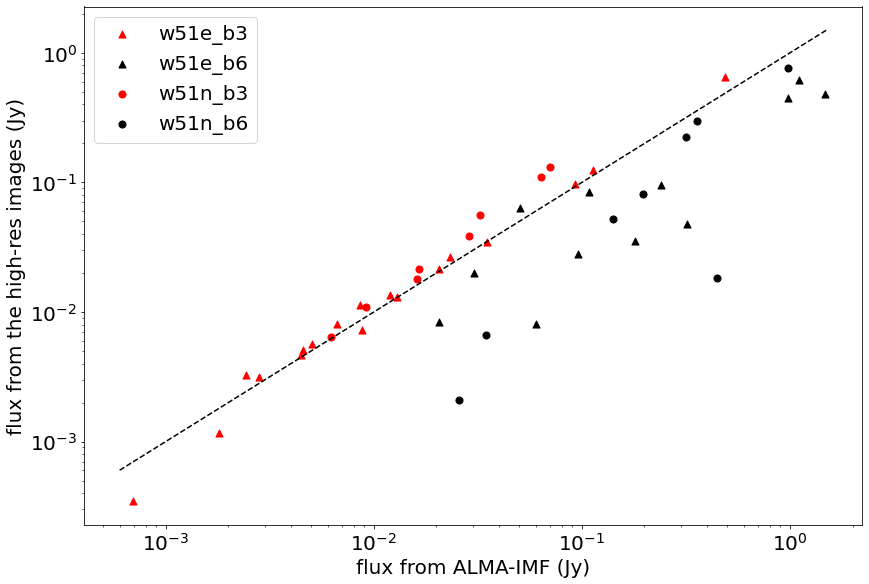

In [16]:

plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
plt.rcParams['legend.fontsize']=20

def plot_flux_comp(ax, dat_hr_b3b6, dat_lr_b3b6, ind_b3b6,
                  catdat_w51,use_rec_ind=False,
                   aperture='fwhm+beam',isfluxcorr=True,label='w51n',colors=['r','k'],marker='o',size=50):

    catdata_w51 = ascii.read(catdat_w51,data_start=0,format='commented_header', header_start=120,  comment="!")
    sky_ra = catdata_w51['WCS_ACOOR']
    sky_dec = catdata_w51['WCS_DCOOR']
    pix_x = catdata_w51['XCO_P']
    pix_y = catdata_w51['YCO_P']
    no = catdata_w51['NO']

    for i, (band, dat_hr, dat_lr, index) in enumerate(zip(['b3','b6'],dat_hr_b3b6,dat_lr_b3b6, ind_b3b6)):
        if band is 'b3':
            bandindex = 3
        elif band is 'b6':
            bandindex = 2

        fooa = catdata_w51['FOOA0%s'%bandindex]
        foob = catdata_w51['FOOB0%s'%bandindex]
        theta = catdata_w51['THETA0%s'%bandindex]
        afwhm = catdata_w51['AFWHM0%s'%bandindex]
        print('afwhm',afwhm)
        bfwhm = catdata_w51['BFWHM0%s'%bandindex]
        flux = catdata_w51['FXT_BST0%s'%bandindex]
        flux_g = catdata_w51['FXT_ALT0%s'%bandindex]


        rec_ind_b3 = np.where((np.abs(catdata_w51['GOODM03'])>1)&
                           (np.abs(catdata_w51['SIGNM03'])>1)&
                           (catdata_w51['FXP_BST03']/catdata_w51['FXP_ERR03']>2)&
                           (catdata_w51['FXT_BST03']/catdata_w51['FXT_ERR03']>2)&
                           (catdata_w51['AFWHM03']/catdata_w51['BFWHM03']<2)&
                           (catdata_w51['FOOA03']/catdata_w51['AFWHM03']>1.15))[0]

        rec_ind_b6 = np.where((np.abs(catdata_w51['GOODM02'])>1)&
                           (np.abs(catdata_w51['SIGNM02'])>1)&
                           (catdata_w51['FXP_BST02']/catdata_w51['FXP_ERR02']>2)&
                           (catdata_w51['FXT_BST02']/catdata_w51['FXT_ERR02']>2)&
                           (catdata_w51['AFWHM02']/catdata_w51['BFWHM02']<2)&
                           (catdata_w51['FOOA02']/catdata_w51['AFWHM02']>1.15))[0]

        rec_ind = np.where((np.abs(catdata_w51['GOODM03'])>1)&
                           (np.abs(catdata_w51['SIGNM03'])>1)&
                           (catdata_w51['FXP_BST03']/catdata_w51['FXP_ERR03']>2)&
                           (catdata_w51['FXT_BST03']/catdata_w51['FXT_ERR03']>2)&
                           (catdata_w51['AFWHM03']/catdata_w51['BFWHM03']<2)&
                           (catdata_w51['FOOA03']/catdata_w51['AFWHM03']>1.15)&
                           (np.abs(catdata_w51['GOODM02'])>1)&
                           (np.abs(catdata_w51['SIGNM02'])>1)&
                           (catdata_w51['FXP_BST02']/catdata_w51['FXP_ERR02']>2)&
                           (catdata_w51['FXT_BST02']/catdata_w51['FXT_ERR02']>2)&
                           (catdata_w51['AFWHM02']/catdata_w51['BFWHM02']<2)&
                           (catdata_w51['FOOA02']/catdata_w51['AFWHM02']>1.15))[0]

        skypos = np.vstack((sky_ra,sky_dec)).T
        print(skypos[index])
        fitsdata_lr = fits.open(dat_lr)
        hdr_lr = fits.getheader(dat_lr)
        wcs_lr = WCS(hdr_lr,naxis=2)
        scale_lr = wcs_lr.proj_plane_pixel_scales()[0]
        beam_lr = Beam.from_fits_header(hdr_lr)
        print(beam_lr.major)
        if aperture is 'footprint':
            major = fooa/3600
            minor = foob/3600
            pa = 180-theta
        elif aperture is 'fwhm+beam':
            meanbeamsize = (beam_lr.major.value+beam_lr.minor.value)/4
            print('meanbeamsize',meanbeamsize)
            major = (afwhm/3600+meanbeamsize/3600)
            minor = (bfwhm/3600+meanbeamsize/3600)
            pa = 180-theta
        elif aperture is 'beam':
            major = beam_lr.major.value
            minor = beam_lr.minor.value
            pa = 180-beam_lr.pa.value




        if use_rec_ind:
            skypos_ind = skypos[rec_ind]
            major = major[rec_ind]
            minor = minor[rec_ind]
            pa = pa[rec_ind]
            no_ind = no[rec_ind]
        else:
            skypos_ind = skypos[index]
            major = major[index]
            minor = minor[index]
            pa = pa[index]
            no_ind = no[index]
        print(major)
        print('no',no_ind)
        image_lr = fitsdata_lr[0].data
        print(image_lr.shape)
        peakxy_lr = wcs_lr.wcs_world2pix(skypos_ind,0) 
        print('peakxy_lr',peakxy_lr)
        if len(image_lr.shape)!=2:
            image_lr = fitsdata_lr[0].data[0][0]
        flux_lr = get_flux(image_lr, peakxy_lr, beam_lr, wcs_lr, scale_lr, major/scale_lr.value,minor/scale_lr.value,pa)
        print('flux_lr',flux_lr)


        fitsdata_hr = fits.open(dat_hr)
        hdr_hr = fits.getheader(dat_hr)
        wcs_hr = WCS(hdr_hr,naxis=2)
        scale_hr = wcs_hr.proj_plane_pixel_scales()[0]
        beam_hr = Beam.from_fits_header(hdr_hr)
        image_hr = fitsdata_hr[0].data
        peakxy_hr = wcs_hr.wcs_world2pix(skypos_ind,0) 
        print('peakxy_hr',peakxy_hr)
        if len(image_hr.shape)!=2:
            image_hr = fitsdata_hr[0].data[0][0]
        print(image_hr.shape)

        flux_hr = get_flux(image_hr, peakxy_hr, beam_hr, wcs_hr, scale_hr, major/scale_hr.value,minor/scale_hr.value,pa)
        print('flux_hr',flux_hr)
        if isfluxcorr:
            for k in range(4):
                if hdr_lr['CTYPE%d'%(k+1)]=='FREQ':
                    hdrind_lr = k+1
                if hdr_hr['CTYPE%d'%(k+1)]=='FREQ':
                    hdrind_hr = k+1
            freq_lr =cen_freq(hdr_lr['CRVAL%d'%hdrind_lr],hdr_lr['CDELT%d'%hdrind_lr])
            freq_hr=cen_freq(hdr_hr['CRVAL%d'%hdrind_hr],hdr_hr['CDELT%d'%hdrind_hr])
            print(freq_lr, freq_hr,hdr_hr['CRVAL4'],hdr_hr['CDELT4'])
            dflux = np.log10(freq_hr/freq_lr)*2.
            flux_corr = np.log10(flux_lr) + dflux
            flux_lr = 10**flux_corr
            print('flux_lr_corr',flux_lr)
        ax.scatter(flux_lr, flux_hr, color=colors[i], label='%s_%s'%(label,band), s=size,marker=marker)

def measure_rms(data, noiseregiondir):
    fitsdata = fits.open(data)
    noiseregion= Regions.read(noiseregiondir,format='ds9')
    image = fitsdata[0].data
    wcs = WCS(fitsdata[0].header,naxis=2)

    container = []
    for reg in noiseregion:
        pix_reg = reg.to_pixel(wcs)
        noisemask = pix_reg.to_mask()
        noiseim = noisemask.cutout(image)
        container.append(noiseim.flatten())
    noiseim = list(chain.from_iterable(container))
    std = stats.mad_std(noiseim,ignore_nan=True)
    return std

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_axes([0.05,0.05,0.9,0.9])
ax1.set_xlabel('flux from ALMA-IMF (Jy)')
ax1.set_ylabel('flux from the high-res images (Jy)')

manualindex = [1, 2, 5, 6, 7, 25, 41, 68]
w51n_b3_index = [i-1 for i in manualindex]

manualindex = [1, 2, 5, 6, 7, 25, 41, 68]
w51n_b6_index = [i-1 for i in manualindex]



manualindex = [1, 2, 4, 5, 8, 10, 12, 13, 14, 15, 16, 19, 23, 25, 27, 28, 38, 41]
w51e_b3_index = [i-1 for i in manualindex]
manualindex = [1, 2, 4, 5, 8, 10, 12, 13, 14, 15, 16, 19, 23, 25, 27, 28, 41]
w51e_b6_index = [i-1 for i in manualindex]
fluxratio_w51e = plot_flux_comp(ax1,  [w51e_b3_tt0, w51e_b6_conv_briggs],[w51e_b3_almaimf_conv,w51e_b6_almaimf_conv],[w51e_b3_index,w51e_b6_index],cat_w51e,label='w51e',marker='^')
fluxratio_w51n = plot_flux_comp(ax1,  [w51n_b3_tt0, w51n_b6_conv_briggs],[w51n_b3_almaimf_conv,w51n_b6_almaimf_conv],[w51n_b3_index,w51n_b6_index],cat_w51n,label='w51n',marker='o')

ax1.legend()
xx = np.array([6e-4,1.5])

ax1.plot(xx,xx, c='k',ls='dashed')
ax1.set_yscale('log')
ax1.set_xscale('log')
#ax1.plot(xx,1e-1*xx, c='k',ls='dashed')


In [ ]:
fluxratio_w51n =  plot_flux_comp(ax1, [w51n_b3_tt0, w51n_b6_conv_briggs],[w51n_b3_almaimf_conv, w51n_b6_almaimf_conv],[w51n_b3_index, w51n_b6_index],cat_w51n)
ax1.set_xscale('log')
ax1.set_yscale('log')
xx = np.array([6e-4,3])
ax1.plot(xx,xx, c='k',ls='dashed')

ax1.plot(xx,1e-1*xx, c='k',ls='dashed')
#ax1.plot(xx,1e-2*xx, c='k',ls='dashed')
#ax1.plot(xx,1e-3*xx, c='k',ls='dashed')
ax1.text(0.15,0.3,'flux(high-res)=flux(ALMA-IMF)',rotation=27,fontsize=15)

ax1.text(0.15,1e-1*0.3,'flux(high-res)=0.1 flux(ALMA-IMF)',rotation=27,fontsize=15)
#ax1.text(0.15,1e-2*0.3,'flux(high-res)=0.01 flux(ALMA-IMF)',rotation=23,fontsize=15)
#ax1.text(0.15,1e-3*0.3,'flux(high-res)=0.001 flux(ALMA-IMF)',rotation=23,fontsize=15)
ax1.legend(fontsize=20)

In [ ]:

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_axes([0.05,0.05,0.9,0.9])
ax1.set_xlabel('flux from ALMA-IMF (Jy)')
ax1.set_ylabel('flux from the high-res images (Jy)')

def plot_flux_comp(ax,
                   dat_hr_w51n,dat_hr_w51e,dat_lr_w51n,dat_lr_w51e,
                   cat_w51n,cat_w51e, ind_w51n,ind_w51e,use_rec_ind=False,
                   aperture='fwhm+beam',isfluxcorr=True,labels=['w51n','w51e'],colors=['r','k'],markers=['o','^'],size=50):
    
    for j,(label, dat_hr_b3b6, dat_lr_b3b6, cat_w51, ind_b3b6) in enumerate(zip(labels,[dat_hr_w51n,dat_hr_w51e],
                                                   [dat_lr_w51n,dat_lr_w51e],
                                                   [cat_w51n, cat_w51e],[ind_w51n,ind_w51e])):
        catdata_w51 = ascii.read(cat_w51,data_start=0,format='commented_header', header_start=120,  comment="!")
        sky_ra = catdata_w51['WCS_ACOOR']
        sky_dec = catdata_w51['WCS_DCOOR']
        pix_x = catdata_w51['XCO_P']
        pix_y = catdata_w51['YCO_P']
        no = catdata_w51['NO']

        for i, (band, dat_hr, dat_lr, index) in enumerate(zip(['b3','b6'],dat_hr_b3b6,dat_lr_b3b6, ind_b3b6)):
            if band is 'b3':
                bandindex = 2
            elif band is 'b6':
                bandindex = 3

            fooa = catdata_w51['FOOA0%s'%bandindex]
            foob = catdata_w51['FOOB0%s'%bandindex]
            theta = catdata_w51['THETA0%s'%bandindex]
            afwhm = catdata_w51['AFWHM0%s'%bandindex]
            bfwhm = catdata_w51['BFWHM0%s'%bandindex]



            flux = catdata_w51['FXT_BST0%s'%bandindex]
            flux_g = catdata_w51['FXT_ALT0%s'%bandindex]


                          

            rec_ind_b3 = np.where((np.abs(catdata_w51['GOODM03'])>1)&
                               (np.abs(catdata_w51['SIGNM03'])>1)&
                               (catdata_w51['FXP_BST03']/catdata_w51['FXP_ERR03']>2)&
                               (catdata_w51['FXT_BST03']/catdata_w51['FXT_ERR03']>2)&
                               (catdata_w51['AFWHM03']/catdata_w51['BFWHM03']<2)&
                               (catdata_w51['FOOA03']/catdata_w51['AFWHM03']>1.15))[0]

            rec_ind_b6 = np.where((np.abs(catdata_w51['GOODM02'])>1)&
                               (np.abs(catdata_w51['SIGNM02'])>1)&
                               (catdata_w51['FXP_BST02']/catdata_w51['FXP_ERR02']>2)&
                               (catdata_w51['FXT_BST02']/catdata_w51['FXT_ERR02']>2)&
                               (catdata_w51['AFWHM02']/catdata_w51['BFWHM02']<2)&
                               (catdata_w51['FOOA02']/catdata_w51['AFWHM02']>1.15))[0]

            rec_ind = np.where((np.abs(catdata_w51['GOODM03'])>1)&
                               (np.abs(catdata_w51['SIGNM03'])>1)&
                               (catdata_w51['FXP_BST03']/catdata_w51['FXP_ERR03']>2)&
                               (catdata_w51['FXT_BST03']/catdata_w51['FXT_ERR03']>2)&
                               (catdata_w51['AFWHM03']/catdata_w51['BFWHM03']<2)&
                               (catdata_w51['FOOA03']/catdata_w51['AFWHM03']>1.15)&
                               (np.abs(catdata_w51['GOODM02'])>1)&
                               (np.abs(catdata_w51['SIGNM02'])>1)&
                               (catdata_w51['FXP_BST02']/catdata_w51['FXP_ERR02']>2)&
                               (catdata_w51['FXT_BST02']/catdata_w51['FXT_ERR02']>2)&
                               (catdata_w51['AFWHM02']/catdata_w51['BFWHM02']<2)&
                               (catdata_w51['FOOA02']/catdata_w51['AFWHM02']>1.15))[0]

            skypos = np.vstack((sky_ra,sky_dec)).T

            fitsdata_lr = fits.open(dat_lr)
            hdr_lr = fits.getheader(dat_lr)
            wcs_lr = WCS(hdr_lr,naxis=2)
            scale_lr = wcs_lr.proj_plane_pixel_scales()[0]
            beam_lr = Beam.from_fits_header(hdr_lr)

            if aperture is 'footprint':
                major = fooa/3600
                minor = foob/3600
                pa = 180-theta
            elif aperture is 'fwhm+beam':
                meanbeamsize = (beam_lr.major.value+beam_lr.minor.value)/4
                major = (afwhm/3600+meanbeamsize)
                minor = (bfwhm/3600+meanbeamsize)
                pa = 180-theta
            elif aperture is 'beam':
                major = beam_lr.major.value
                minor = beam_lr.minor.value
                pa = 180-beam_lr.pa.value

            
            
                
            if use_rec_ind:
                skypos = skypos[rec_ind]
                major = major[rec_ind]
                minor = minor[rec_ind]
                pa = pa[rec_ind]
            else:
                skypos = skypos[index]
                major = major[index]
                minor = minor[index]
                pa = pa[index]
            print('major',major)
                
            image_lr = fitsdata_lr[0].data
            peakxy_lr = wcs_lr.wcs_world2pix(skypos,0) 
            if len(image_lr.shape)!=2:
                image_lr = fitsdata_lr[0].data[0][0]
            
            flux_lr = get_flux(image_lr, peakxy_lr, beam_lr, wcs_lr, scale_lr, major/scale_lr.value,minor/scale_lr.value,pa)

          



            fitsdata_hr = fits.open(dat_hr)
            hdr_hr = fits.getheader(dat_hr)
            wcs_hr = WCS(hdr_hr,naxis=2)
            scale_hr = wcs_hr.proj_plane_pixel_scales()[0]
            beam_hr = Beam.from_fits_header(hdr_hr)
            image_hr = fitsdata_hr[0].data
            peakxy_hr = wcs_hr.wcs_world2pix(skypos,0) 
            if len(image_hr.shape)!=2:
                image_hr = fitsdata_hr[0].data[0][0]
            flux_hr = get_flux(image_hr, peakxy_hr, beam_hr, wcs_hr, scale_hr, major/scale_hr.value,minor/scale_hr.value,pa)
            print(flux_lr)
            if isfluxcorr:
                for k in range(4):
                    if hdr_lr['CTYPE%d'%(k+1)]=='FREQ':
                        hdrind_lr = k+1
                    if hdr_hr['CTYPE%d'%(k+1)]=='FREQ':
                        hdrind_hr = k+1
                freq_lr =cen_freq(hdr_lr['CRVAL%d'%hdrind_lr],hdr_lr['CDELT%d'%hdrind_lr])
                freq_hr=cen_freq(hdr_hr['CRVAL%d'%hdrind_hr],hdr_hr['CDELT%d'%hdrind_hr])
                print(freq_lr, freq_hr,hdr_hr['CRVAL4'],hdr_hr['CDELT4'])
                dflux = np.log10(freq_hr/freq_lr)*2.
                flux_corr = np.log10(flux_lr) + dflux
                flux_lr = 10**flux_corr
                print(flux_lr)
            ax.scatter(flux_lr, flux_hr, color=colors[i], label='%s_%s'%(label,band), s=size,marker=markers[j])
            




manualindex = [1, 2, 5, 6, 7, 25, 41, 68]
w51n_b3_index = [i-1 for i in manualindex]

manualindex = [1, 2, 5, 6, 7, 25, 41, 68]
w51n_b6_index = [i-1 for i in manualindex]



manualindex = [1, 2, 4, 5, 8, 10, 12, 13, 14, 15, 16, 19, 23, 25, 27, 28, 38, 41]
w51e_b3_index = [i-1 for i in manualindex]
manualindex = [1, 2, 4, 5, 8, 10, 12, 13, 14, 15, 16, 19, 23, 25, 27, 28, 41]
w51e_b6_index = [i-1 for i in manualindex]

fluxratio_w51e_b3 = plot_flux_comp(ax1,  [w51n_b3_tt0, w51n_b6_conv_briggs], [w51e_b3_tt0, w51e_b6_conv_briggs], 
                                   [w51n_b3_almaimf_conv, w51n_b6_almaimf_conv], [w51e_b3_almaimf_conv,w51e_b6_almaimf_conv],cat_w51n,cat_w51e,
                                   [w51n_b3_index, w51n_b6_index], [w51e_b3_index,w51e_b6_index],
                                    )
ax1.set_xscale('log')
ax1.set_yscale('log')
xx = np.array([6e-4,3])
ax1.plot(xx,xx, c='k',ls='dashed')

ax1.plot(xx,1e-1*xx, c='k',ls='dashed')
#ax1.plot(xx,1e-2*xx, c='k',ls='dashed')
#ax1.plot(xx,1e-3*xx, c='k',ls='dashed')
ax1.text(0.15,0.3,'flux(high-res)=flux(ALMA-IMF)',rotation=27,fontsize=15)

ax1.text(0.15,1e-1*0.3,'flux(high-res)=0.1 flux(ALMA-IMF)',rotation=27,fontsize=15)
#ax1.text(0.15,1e-2*0.3,'flux(high-res)=0.01 flux(ALMA-IMF)',rotation=23,fontsize=15)
#ax1.text(0.15,1e-3*0.3,'flux(high-res)=0.001 flux(ALMA-IMF)',rotation=23,fontsize=15)
ax1.legend(fontsize=20)


In [ ]:

catdata_w51n = ascii.read(cat_w51n,data_start=0,format='commented_header', header_start=120,  comment="!")
sky_ra = catdata_w51n['WCS_ACOOR']
sky_dec = catdata_w51n['WCS_DCOOR']
pix_x = catdata_w51n['XCO_P']
pix_y = catdata_w51n['YCO_P']

afwhm_b6 = catdata_w51n['AFWHM02']
bfwhm_b6 = catdata_w51n['BFWHM02']

asize_b6 = catdata_w51n['ASIZE02']
bsize_b6 = catdata_w51n['BSIZE02']

theta_b6 = catdata_w51n['THETA02']

afwhm_b3 = catdata_w51n['AFWHM03']
bfwhm_b3 = catdata_w51n['BFWHM03']

asize_b3 = catdata_w51n['ASIZE03']
bsize_b3 = catdata_w51n['BSIZE03']

theta_b3 = catdata_w51n['THETA03']

flux_b3 = catdata_w51n['FXT_BST03']
flux_g_b3 = catdata_w51n['FXT_ALT03']

flux_b6 = catdata_w51n['FXT_BST02']
flux_g_b6 = catdata_w51n['FXT_ALT02']
fooa_b6 = catdata_w51n['FOOA02']
foob_b6 = catdata_w51n['FOOB02']
fofa_b6 = catdata_w51n['FOFA02']
fooa_b3 = catdata_w51n['FOOA03']
foob_b3 = catdata_w51n['FOOB03']
fofa_b3 = catdata_w51n['FOFA03']
no = catdata_w51n['NO']

rec_ind_b3 = np.where((np.abs(catdata_w51n['GOODM03'])>1)&
                   (np.abs(catdata_w51n['SIGNM03'])>1)&
                   (catdata_w51n['FXP_BST03']/catdata_w51n['FXP_ERR03']>2)&
                   (catdata_w51n['FXT_BST03']/catdata_w51n['FXT_ERR03']>2)&
                   (catdata_w51n['AFWHM03']/catdata_w51n['BFWHM03']<2)&
                   (catdata_w51n['FOOA03']/catdata_w51n['AFWHM03']>1.15))[0]

rec_ind_b6 = np.where((np.abs(catdata_w51n['GOODM02'])>1)&
                   (np.abs(catdata_w51n['SIGNM02'])>1)&
                   (catdata_w51n['FXP_BST02']/catdata_w51n['FXP_ERR02']>2)&
                   (catdata_w51n['FXT_BST02']/catdata_w51n['FXT_ERR02']>2)&
                   (catdata_w51n['AFWHM02']/catdata_w51n['BFWHM02']<2)&
                   (catdata_w51n['FOOA02']/catdata_w51n['AFWHM02']>1.15))[0]

skypos = np.vstack((sky_ra,sky_dec)).T





In [ ]:

plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.colors
import os
#from matplotlib.patches import Rectangle, Ellipse

def get_flux(image,peakxy, beam1, wcsNB, pixel_scale, issky=False,savedir=None,major_ai=None, minor_ai=None,
            pa_ai = None):
    fluxarr = []

    if issky:
        cen_world = peakxy
    else:
        cen_world = wcsNB.wcs_pix2world(peakxy,0)
    num_source = len(cen_world)
   
    
    for i in range(num_source):
        
        #x_cen = peakxy[i][0]
        #y_cen = peakxy[i][1]
        #cen = (x_cen, y_cen)
        
        major = beam1.major
        minor = beam1.minor
        pa = beam1.pa
        area = beam1.sr.value
        
        beamarea = area
        if major_ai is not None:
            major = major_ai[i] / 3600 *u.deg
            minor = minor_ai[i] / 3600 *u.deg
            pa = pa_ai[i]*u.deg
            area = np.pi *(major.value/2*np.pi/180)*(minor.value/2*np.pi/180)
            
                  
        
        positions = coordinates.SkyCoord(cen_world[i,0],cen_world[i,1], frame=wcs.utils.wcs_to_celestial_frame(wcsNB).name,unit=(u.deg,u.deg))
        cutout = Cutout2D(image, positions, 4.0*major, wcs=wcsNB, mode='partial')
        frame = wcs.utils.wcs_to_celestial_frame(cutout.wcs).name
    
        aperture = Ellipse(positions, major, minor, -1*pa, unit=u.deg, frame=frame) # pa in degree with anti-clockwise direction
        this_mask = aperture.place(cutout.data, wcs=cutout.wcs)
        pixel_scale_sr = (pixel_scale.value * np.pi/180)**2 # pixel scale in deg^2 -> sr
        fluxarr.append(np.sum(cutout.data[this_mask]/beamarea*pixel_scale_sr)) # Jy/beam / (sr/beam) * (sr/pixel) = Jy/ pixel
        if savedir is not None:
            if not os.path.isdir(savedir):
                os.mkdir(savedir)
            else:
                fig = plt.figure(figsize=(10,10))
                ax1=fig.add_axes([0.2,0.2,0.8,0.8],projection=wcsNB)
                ax1.imshow(cutout.data, origin='lower')
                ax1.imshow(this_mask, origin='lower',alpha=0.1,cmap='gray')
                plt.savefig(savedir+'aper_%04d.png'%i)
                plt.close()
    return fluxarr

def plot_flux_comp(ax, data, skypos, major, minor, pa, flux_almaimf, index,
                   marker='o',label='w51n B3',color='k',s=50,savedirlabel='w51nB3'
                   ,hdrHR=None, ):
    fitsdata = fits.open(data)
    image = fitsdata[0].data
    if len(image.shape)!=2:
        image = fitsdata[0].data[0][0]
    hdrNB = fits.getheader(data)  
    wcsNB = WCS(hdrNB,naxis=2)
    scaleNB = wcsNB.proj_plane_pixel_scales()[0]
    my_beamNB = Beam.from_fits_header(hdrNB)
    
    
   
    flux = get_flux(image, skypos[index], my_beamNB, wcsNB, scaleNB, issky=True,
                   major_ai = major[index], minor_ai = minor[index], pa_ai = pa[index],
                   savedir='cutout_from_comparison/%s/'%savedirlabel)
    if hdrHR is not None:
        freqHR =cen_freq(hdrHR['CRVAL3'],hdrHR['CDELT4'])
        freq=cen_freq(hdrNB['CRVAL3'],hdrNB['CDELT4'])
        dflux = np.log10(freqHR/freq)*2.
        flux_corr = np.log10(flux) + dflux
        flux = 10**flux_corr
    print(flux_almaimf[index], flux)
    ax1.scatter(flux_almaimf[index], flux, marker=marker, label=label, c=color,s=s)
    
    return flux_almaimf[index]/flux



    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_axes([0.05,0.05,0.9,0.9])
ax1.set_xlabel('flux from ALMA-IMF (Jy)')
ax1.set_ylabel('flux from the high-res images (Jy)')

manualindex = [1,6,3,5,8,68]
index = [i-1 for i in manualindex]
fluxratio_w51n_b3 = plot_flux_comp(ax1, w51n_b3_tt0, skypos, fooa_b3, foob_b3, theta_b3, flux_b3, index)
fluxratio_w51n_b6 = plot_flux_comp(ax1, w51n_b6_conv_briggs, skypos, fooa_b6, foob_b6, theta_b6, flux_b6, index,color='r',label='w51n B6',savedirlabel='w51nB6')
ax1.legend()
               





catdata_w51n = ascii.read(cat_w51e,data_start=0,format='commented_header', header_start=120,  comment="!")
sky_ra = catdata_w51n['WCS_ACOOR']
sky_dec = catdata_w51n['WCS_DCOOR']
pix_x = catdata_w51n['XCO_P']
pix_y = catdata_w51n['YCO_P']

afwhm_b6 = catdata_w51n['AFWHM02']
bfwhm_b6 = catdata_w51n['BFWHM02']

asize_b6 = catdata_w51n['ASIZE02']
bsize_b6 = catdata_w51n['BSIZE02']

theta_b6 = catdata_w51n['THETA02']

afwhm_b3 = catdata_w51n['AFWHM03']
bfwhm_b3 = catdata_w51n['BFWHM03']

asize_b3 = catdata_w51n['ASIZE03']
bsize_b3 = catdata_w51n['BSIZE03']

theta_b3 = catdata_w51n['THETA03']

flux_b3 = catdata_w51n['FXT_BST03']
flux_g_b3 = catdata_w51n['FXT_ALT03']

flux_b6 = catdata_w51n['FXT_BST02']
flux_g_b6 = catdata_w51n['FXT_ALT02']
fooa_b6 = catdata_w51n['FOOA02']
foob_b6 = catdata_w51n['FOOB02']
fofa_b6 = catdata_w51n['FOFA02']
fooa_b3 = catdata_w51n['FOOA03']
foob_b3 = catdata_w51n['FOOB03']
fofa_b3 = catdata_w51n['FOFA03']
no = catdata_w51n['NO']

rec_ind_b3 = np.where((np.abs(catdata_w51n['GOODM03'])>1)&
                   (np.abs(catdata_w51n['SIGNM03'])>1)&
                   (catdata_w51n['FXP_BST03']/catdata_w51n['FXP_ERR03']>2)&
                   (catdata_w51n['FXT_BST03']/catdata_w51n['FXT_ERR03']>2)&
                   (catdata_w51n['AFWHM03']/catdata_w51n['BFWHM03']<2)&
                   (catdata_w51n['FOOA03']/catdata_w51n['AFWHM03']>1.15))[0]

rec_ind_b6 = np.where((np.abs(catdata_w51n['GOODM02'])>1)&
                   (np.abs(catdata_w51n['SIGNM02'])>1)&
                   (catdata_w51n['FXP_BST02']/catdata_w51n['FXP_ERR02']>2)&
                   (catdata_w51n['FXT_BST02']/catdata_w51n['FXT_ERR02']>2)&
                   (catdata_w51n['AFWHM02']/catdata_w51n['BFWHM02']<2)&
                   (catdata_w51n['FOOA02']/catdata_w51n['AFWHM02']>1.15))[0]

skypos = np.vstack((sky_ra,sky_dec)).T



manualindex = [12,10,6,38,1,3,29,30,4,17,25,21,7,13,11]
index = [i-1 for i in manualindex]

fluxratio_w51e_b3 = plot_flux_comp(ax1, w51e_b3_tt0, skypos, fooa_b3, foob_b3, theta_b3, flux_b3, index, marker='^', label='w51e B3',savedirlabel='w51eB3')
fluxratio_w51e_b6 = plot_flux_comp(ax1, w51e_b6_conv_briggs, skypos, fooa_b6, foob_b6, theta_b6, flux_b6, index,marker='^',color='r',label='w51e B6',savedirlabel='w51eB6')
ax1.set_xscale('log')
ax1.set_yscale('log')
xx = np.array([6e-4,3])
ax1.plot(xx,xx, c='k',ls='dashed')

ax1.plot(xx,1e-1*xx, c='k',ls='dashed')
#ax1.plot(xx,1e-2*xx, c='k',ls='dashed')
#ax1.plot(xx,1e-3*xx, c='k',ls='dashed')
ax1.text(0.15,0.3,'flux(high-res)=flux(ALMA-IMF)',rotation=27,fontsize=15)

ax1.text(0.15,1e-1*0.3,'flux(high-res)=0.1 flux(ALMA-IMF)',rotation=27,fontsize=15)
#ax1.text(0.15,1e-2*0.3,'flux(high-res)=0.01 flux(ALMA-IMF)',rotation=23,fontsize=15)
#ax1.text(0.15,1e-3*0.3,'flux(high-res)=0.001 flux(ALMA-IMF)',rotation=23,fontsize=15)
ax1.legend(fontsize=20)


In [ ]:
catdata_w51n = ascii.read(cat_w51n,data_start=0,format='commented_header', header_start=120,  comment="!")
sky_ra = catdata_w51n['WCS_ACOOR']
sky_dec = catdata_w51n['WCS_DCOOR']
pix_x = catdata_w51n['XCO_P']
pix_y = catdata_w51n['YCO_P']

afwhm_b6 = catdata_w51n['AFWHM02']
bfwhm_b6 = catdata_w51n['BFWHM02']

asize_b6 = catdata_w51n['ASIZE02']
bsize_b6 = catdata_w51n['BSIZE02']

theta_b6 = catdata_w51n['THETA02']

afwhm_b3 = catdata_w51n['AFWHM03']
bfwhm_b3 = catdata_w51n['BFWHM03']

asize_b3 = catdata_w51n['ASIZE03']
bsize_b3 = catdata_w51n['BSIZE03']

theta_b3 = catdata_w51n['THETA03']

flux_b3 = catdata_w51n['FXT_BST03']
flux_g_b3 = catdata_w51n['FXT_ALT03']

flux_b6 = catdata_w51n['FXT_BST02']
flux_g_b6 = catdata_w51n['FXT_ALT02']
fooa_b6 = catdata_w51n['FOOA02']
foob_b6 = catdata_w51n['FOOB02']
fofa_b6 = catdata_w51n['FOFA02']
fooa_b3 = catdata_w51n['FOOA03']
foob_b3 = catdata_w51n['FOOB03']
fofa_b3 = catdata_w51n['FOFA03']
no = catdata_w51n['NO']

rec_ind_b3 = np.where((np.abs(catdata_w51n['GOODM03'])>1)&
                   (np.abs(catdata_w51n['SIGNM03'])>1)&
                   (catdata_w51n['FXP_BST03']/catdata_w51n['FXP_ERR03']>2)&
                   (catdata_w51n['FXT_BST03']/catdata_w51n['FXT_ERR03']>2)&
                   (catdata_w51n['AFWHM03']/catdata_w51n['BFWHM03']<2)&
                   (catdata_w51n['FOOA03']/catdata_w51n['AFWHM03']>1.15))[0]

rec_ind_b6 = np.where((np.abs(catdata_w51n['GOODM02'])>1)&
                   (np.abs(catdata_w51n['SIGNM02'])>1)&
                   (catdata_w51n['FXP_BST02']/catdata_w51n['FXP_ERR02']>2)&
                   (catdata_w51n['FXT_BST02']/catdata_w51n['FXT_ERR02']>2)&
                   (catdata_w51n['AFWHM02']/catdata_w51n['BFWHM02']<2)&
                   (catdata_w51n['FOOA02']/catdata_w51n['AFWHM02']>1.15))[0]

skypos = np.vstack((sky_ra,sky_dec)).T

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_axes([0.05,0.05,0.9,0.9])
ax1.set_xlabel('flux from ALMA-IMF (Jy)')
ax1.set_ylabel('flux from the high-res images (Jy)')

manualindex = [1,6,3,5,8,68]
index = [i-1 for i in manualindex]
fluxratio_w51n_b3 = plot_flux_comp(ax1, w51n_b3_tt0, skypos, afwhm_b3, bfwhm_b3, theta_b3, flux_g_b3, index)
fluxratio_w51n_b6 = plot_flux_comp(ax1, w51n_b6_conv_briggs, skypos, afwhm_b6, bfwhm_b6, theta_b6, flux_g_b6, index,color='r',label='w51n B6',savedirlabel='w51nB6')
ax1.legend()
               





catdata_w51n = ascii.read(cat_w51e,data_start=0,format='commented_header', header_start=120,  comment="!")
sky_ra = catdata_w51n['WCS_ACOOR']
sky_dec = catdata_w51n['WCS_DCOOR']
pix_x = catdata_w51n['XCO_P']
pix_y = catdata_w51n['YCO_P']

afwhm_b6 = catdata_w51n['AFWHM02']
bfwhm_b6 = catdata_w51n['BFWHM02']

asize_b6 = catdata_w51n['ASIZE02']
bsize_b6 = catdata_w51n['BSIZE02']

theta_b6 = catdata_w51n['THETA02']

afwhm_b3 = catdata_w51n['AFWHM03']
bfwhm_b3 = catdata_w51n['BFWHM03']

asize_b3 = catdata_w51n['ASIZE03']
bsize_b3 = catdata_w51n['BSIZE03']

theta_b3 = catdata_w51n['THETA03']

flux_b3 = catdata_w51n['FXT_BST03']
flux_g_b3 = catdata_w51n['FXT_ALT03']

flux_b6 = catdata_w51n['FXT_BST02']
flux_g_b6 = catdata_w51n['FXT_ALT02']
fooa_b6 = catdata_w51n['FOOA02']
foob_b6 = catdata_w51n['FOOB02']
fofa_b6 = catdata_w51n['FOFA02']
fooa_b3 = catdata_w51n['FOOA03']
foob_b3 = catdata_w51n['FOOB03']
fofa_b3 = catdata_w51n['FOFA03']
no = catdata_w51n['NO']

rec_ind_b3 = np.where((np.abs(catdata_w51n['GOODM03'])>1)&
                   (np.abs(catdata_w51n['SIGNM03'])>1)&
                   (catdata_w51n['FXP_BST03']/catdata_w51n['FXP_ERR03']>2)&
                   (catdata_w51n['FXT_BST03']/catdata_w51n['FXT_ERR03']>2)&
                   (catdata_w51n['AFWHM03']/catdata_w51n['BFWHM03']<2)&
                   (catdata_w51n['FOOA03']/catdata_w51n['AFWHM03']>1.15))[0]

rec_ind_b6 = np.where((np.abs(catdata_w51n['GOODM02'])>1)&
                   (np.abs(catdata_w51n['SIGNM02'])>1)&
                   (catdata_w51n['FXP_BST02']/catdata_w51n['FXP_ERR02']>2)&
                   (catdata_w51n['FXT_BST02']/catdata_w51n['FXT_ERR02']>2)&
                   (catdata_w51n['AFWHM02']/catdata_w51n['BFWHM02']<2)&
                   (catdata_w51n['FOOA02']/catdata_w51n['AFWHM02']>1.15))[0]

skypos = np.vstack((sky_ra,sky_dec)).T



manualindex = [12,10,6,38,1,3,29,30,4,17,25,21,7,13,11]
index = [i-1 for i in manualindex]

fluxratio_w51e_b3 = plot_flux_comp(ax1, w51e_b3_tt0, skypos, afwhm_b3, bfwhm_b3, theta_b3, flux_g_b3, index, marker='^', label='w51e B3',savedirlabel='w51eB3')
fluxratio_w51e_b6 = plot_flux_comp(ax1, w51e_b6_conv_briggs, skypos, afwhm_b6, bfwhm_b6, theta_b6, flux_g_b6, index,marker='^',color='r',label='w51e B6',savedirlabel='w51eB6')
ax1.set_xscale('log')
ax1.set_yscale('log')
xx = np.array([6e-4,3])
ax1.plot(xx,xx, c='k',ls='dashed')

ax1.plot(xx,1e-1*xx, c='k',ls='dashed')
#ax1.plot(xx,1e-2*xx, c='k',ls='dashed')
#ax1.plot(xx,1e-3*xx, c='k',ls='dashed')
ax1.text(0.15,0.3,'flux(high-res)=flux(ALMA-IMF)',rotation=27,fontsize=15)

ax1.text(0.15,1e-1*0.3,'flux(high-res)=0.1 flux(ALMA-IMF)',rotation=27,fontsize=15)
#ax1.text(0.15,1e-2*0.3,'flux(high-res)=0.01 flux(ALMA-IMF)',rotation=23,fontsize=15)
#ax1.text(0.15,1e-3*0.3,'flux(high-res)=0.001 flux(ALMA-IMF)',rotation=23,fontsize=15)
ax1.legend(fontsize=20)


In [ ]:
def count_points_in_ellipse(xcen,ycen,major,minor,pa,xpos,ypos):
    # calculate foci positions 
    # must be full major, minor not semi major, minor
    fodx = np.cos(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    fody = np.sin(pa)*np.sqrt((major/2)**2-(minor/2)**2)
    
    fox1 = xcen + fodx
    foy1 = ycen + fody
    
    fox2 = xcen - fodx
    foy2 = ycen - fody
    
    dist1 = np.sqrt((xpos-fox1)**2+(ypos-foy1)**2)
    dist2 = np.sqrt((xpos-fox2)**2+(ypos-foy2)**2)
    
    isinside = np.where(dist1+dist2<major)[0]
    
    return len(isinside), isinside



def plot_alpha_to_fluxratio(ax,data, dendrotable, catadata, index, 
                            color='k',isB3=True, include_unmatched=False,marker='o',label='w51n B6',
                            add_text=False, isgaussian=True, ishist=False,hatch=None):
    if isB3:
        bandindic=3
    else:
        bandindic=2
    sky_ra = catadata['WCS_ACOOR'][index]
    sky_dec = catadata['WCS_DCOOR'][index]    
    afwhm = catadata['AFWHM0%d'%bandindic][index]
    bfwhm = catadata['BFWHM0%d'%bandindic][index]
    asize = catadata['ASIZE0%d'%bandindic][index]
    bsize = catadata['BSIZE0%d'%bandindic][index]
    theta = catadata['THETA0%d'%bandindic][index]
    flux = catadata['FXT_BST0%d'%bandindic][index]
    flux_g = catadata['FXT_ALT0%d'%bandindic][index]
    no = catadata['NO'][index]
    
   
    fofa= catdata_w51n['FOFA0%d'%bandindic][index]
    fooa= catdata_w51n['FOOA0%d'%bandindic][index]
    foob = catdata_w51n['FOOB0%d'%bandindic][index]


    skypos = np.vstack((sky_ra,sky_dec)).T

    
    numalmaimf = len(sky_ra)
    
    fitsdata = fits.open(data)
    image = fitsdata[0].data
    if len(image.shape)!=2:
        image = fitsdata[0].data[0][0]
    hdrNB = fits.getheader(data)  
    wcsNB = WCS(hdrNB,naxis=2)
    my_beamNB = Beam.from_fits_header(hdrNB)
    scaleNB = wcsNB.proj_plane_pixel_scales()[0]

    pixpos = wcsNB.wcs_world2pix(skypos,0)
    
    
    #kind = dendrotable['kind']
    #xpix = dendrotable['x_pix']
    #ypix = dendrotable['y_pix']
    #alpha = dendrotable['alpha']
    if isB3:
        bandindic2=3
    else:
        bandindic2=6
    
    xpis = dendrotable['x_pix_b%d'%bandindic2]
    ypis = dendrotable['y_pix_b%d'%bandindic2]
    alpha = dendrotable['alpha']
    ismatched = dendrotable['ismatched_b%d'%bandindic2]
    


    
    if include_unmatched:
        ind = np.arange(len(xpis))
    else:
        ind = np.where(ismatched)[0]
    
    xpix_selected = xpis[ind]
    ypix_selected = ypis[ind]
    alpha_selected = alpha[ind]
    
    if isgaussian:
        major = fooa
        minor = foob
        almaimfflux = flux_g
    else:
        major = afwhm
        minor = bfwhm
        almaimfflux = flux

    
    highresflux = get_flux(image, skypos, my_beamNB, wcsNB, scaleNB, issky=True,
                   major_ai = major, minor_ai = minor, pa_ai = theta)
    
    if ishist:
        bins = np.linspace(-0.5,2.5,13)
        
        ax1.hist(highresflux/almaimfflux, bins=bins,alpha=0.5,edgecolor=color,facecolor=color,label=label,hatch=hatch)
        ax1.legend()
    else:
    
        for i in range(numalmaimf):
            #print(pixpos[i,0],pixpos[i,1],afwhm[i],xpix_selected,ypix_selected)
            numinside, indinside = count_points_in_ellipse(
                pixpos[i,0],pixpos[i,1],fooa[i]/3600/scaleNB.value,foob[i]/3600/scaleNB.value
                ,theta[i],xpix_selected,ypix_selected)
            print(indinside)
            if i==0:
                ax1.scatter(highresflux[i]/almaimfflux[i]*np.ones(numinside),alpha_selected[indinside],c=color,s=40,marker=marker,label=label)
            else:
                ax1.scatter(highresflux[i]/almaimfflux[i]*np.ones(numinside),alpha_selected[indinside],c=color,s=40,marker=marker)
            if add_text:
                for indd in indinside:
                    ax1.text(highresflux[i]/almaimfflux[i]+0.02,alpha_selected[indd]+0.05,'%s'%no[i])

        ax1.set_xlabel('$F_{high-res}/F_{ALMA-IMF}$')
        ax1.set_ylabel('spectral index')

        ax1.legend(fontsize=25)

    
    
    

In [ ]:
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_axes([0.05,0.05,0.9,0.9])

t_w51n_b6 = Table.read('../alpha/w51n_b6_catalog.fits',format='fits')
t_w51n_b3 = Table.read('../alpha/w51n_b3_catalog.fits',format='fits')
t_w51e_b6 = Table.read('../alpha/w51e_b6_catalog.fits',format='fits')
t_w51e_b3 = Table.read('../alpha/w51e_b3_catalog.fits',format='fits')
catdata_w51n = ascii.read(cat_w51n,data_start=0,format='commented_header', header_start=120,  comment="!")

catdata_w51e = ascii.read(cat_w51e,data_start=0,format='commented_header', header_start=120,  comment="!")

manualindex = [1,6,3,5,8,68]
index = [i-1 for i in manualindex]

plot_alpha_to_fluxratio(ax1,w51n_b6_conv_briggs, t_w51n_b6, catdata_w51n, index, 
                            color='r',isB3=False, include_unmatched=False,label='w51n B6',add_text=True,ishist=True,hatch='/')

plot_alpha_to_fluxratio(ax1,w51n_b3_tt0, t_w51n_b3, catdata_w51n, index, 
                            color='b',isB3=True, include_unmatched=False,label='w51n B3',add_text=True,ishist=True,hatch='\\')
manualindex = [12,10,6,38,1,3,29,30,4,17,25,21,7,13,11]
index = [i-1 for i in manualindex]
plot_alpha_to_fluxratio(ax1,w51e_b6_conv_briggs, t_w51e_b6, catdata_w51e, index, 
                            color='orange',isB3=False, include_unmatched=False,marker='^',label='w51e B6',add_text=True,ishist=True,hatch='.')

plot_alpha_to_fluxratio(ax1,w51e_b3_tt0, t_w51e_b3, catdata_w51e, index, 
                            color='cyan',isB3=True, include_unmatched=False,marker='^',label='w51e B3',add_text=True,ishist=True,hatch='*')



In [ ]:
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_axes([0.05,0.05,0.9,0.9])

t_w51n_b6 = Table.read('../alpha/w51n_b6_catalog.fits',format='fits')
t_w51n_b3 = Table.read('../alpha/w51n_b3_catalog.fits',format='fits')
t_w51e_b6 = Table.read('../alpha/w51e_b6_catalog.fits',format='fits')
t_w51e_b3 = Table.read('../alpha/w51e_b3_catalog.fits',format='fits')
catdata_w51n = ascii.read(cat_w51n,data_start=0,format='commented_header', header_start=120,  comment="!")

catdata_w51e = ascii.read(cat_w51e,data_start=0,format='commented_header', header_start=120,  comment="!")

manualindex = [1,6,3,5,8,68]
index = [i-1 for i in manualindex]

plot_alpha_to_fluxratio(ax1,w51n_b6_conv_briggs, t_w51n_b6, catdata_w51n, index, 
                            color='r',isB3=False, include_unmatched=False,label='w51n B6',add_text=True)

plot_alpha_to_fluxratio(ax1,w51n_b3_tt0, t_w51n_b3, catdata_w51n, index, 
                            color='k',isB3=True, include_unmatched=False,label='w51n B3',add_text=True)
manualindex = [12,10,6,38,1,3,29,30,4,17,25,21,7,13,11]
index = [i-1 for i in manualindex]
plot_alpha_to_fluxratio(ax1,w51e_b6_conv_briggs, t_w51e_b6, catdata_w51e, index, 
                            color='r',isB3=False, include_unmatched=False,marker='^',label='w51e B6',add_text=True)

plot_alpha_to_fluxratio(ax1,w51e_b3_tt0, t_w51e_b3, catdata_w51e, index, 
                            color='k',isB3=True, include_unmatched=False,marker='^',label='w51e B3',add_text=True)



In [ ]:
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_axes([0.05,0.05,0.9,0.9])

t_w51n_b6 = Table.read('../alpha/w51n_b6_catalog.fits',format='fits')
t_w51n_b3 = Table.read('../alpha/w51n_b3_catalog.fits',format='fits')
t_w51e_b6 = Table.read('../alpha/w51e_b6_catalog.fits',format='fits')
t_w51e_b3 = Table.read('../alpha/w51e_b3_catalog.fits',format='fits')
catdata_w51n = ascii.read(cat_w51n,data_start=0,format='commented_header', header_start=120,  comment="!")

catdata_w51e = ascii.read(cat_w51e,data_start=0,format='commented_header', header_start=120,  comment="!")

manualindex = [1,6,3,5,8,68]
index = [i-1 for i in manualindex]

plot_alpha_to_fluxratio(ax1,w51n_b6_conv_briggs, t_w51n_b6, catdata_w51n, index, 
                            color='r',isB3=False, include_unmatched=False,label='w51n B6',add_text=True)

plot_alpha_to_fluxratio(ax1,w51n_b3_tt0, t_w51n_b3, catdata_w51n, index, 
                            color='k',isB3=True, include_unmatched=False,label='w51n B3',add_text=True)
manualindex = [12,10,6,38,1,3,29,30,4,17,25,21,7,13,11]
index = [i-1 for i in manualindex]
plot_alpha_to_fluxratio(ax1,w51e_b6_conv_briggs, t_w51e_b6, catdata_w51e, index, 
                            color='r',isB3=False, include_unmatched=False,marker='^',label='w51e B6',add_text=True)

plot_alpha_to_fluxratio(ax1,w51e_b3_tt0, t_w51e_b3, catdata_w51e, index, 
                            color='k',isB3=True, include_unmatched=False,marker='^',label='w51e B3',add_text=True)



In [ ]:
    
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_axes([0.05,0.05,0.9,0.9])

t_w51n_b6 = Table.read('../alpha/w51n_b6_catalog.fits',format='fits')
t_w51n_b3 = Table.read('../alpha/w51n_b3_catalog.fits',format='fits')
t_w51e_b6 = Table.read('../alpha/w51e_b6_catalog.fits',format='fits')
t_w51e_b3 = Table.read('../alpha/w51e_b3_catalog.fits',format='fits')
catdata_w51n = ascii.read(cat_w51n,data_start=0,format='commented_header', header_start=120,  comment="!")

catdata_w51e = ascii.read(cat_w51e,data_start=0,format='commented_header', header_start=120,  comment="!")

manualindex = [1,6,3,5,8,68]
index = [i-1 for i in manualindex]

plot_alpha_to_fluxratio(ax1,w51n_b6_conv_briggs, t_w51n_b6, catdata_w51n, index, 
                            color='r',isB3=False, include_unmatched=True,label='w51n B6',add_text=True)

plot_alpha_to_fluxratio(ax1,w51n_b3_tt0, t_w51n_b3, catdata_w51n, index, 
                            color='k',isB3=True, include_unmatched=True,label='w51n B3',add_text=True)
manualindex = [12,10,6,38,1,3,29,30,4,17,25,21,7,13,11]
index = [i-1 for i in manualindex]
plot_alpha_to_fluxratio(ax1,w51e_b6_conv_briggs, t_w51e_b6, catdata_w51e, index, 
                            color='r',isB3=False, include_unmatched=True,marker='^',label='w51e B6',add_text=True)

plot_alpha_to_fluxratio(ax1,w51e_b3_tt0, t_w51e_b3, catdata_w51e, index, 
                            color='k',isB3=True, include_unmatched=True,marker='^',label='w51e B3',add_text=True)

